In [43]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager
import time

In [2]:
from scraping_cleaning_data import import_data, get_prices, filter_holofoil_data

In [4]:
df1=import_data()
df=filter_holofoil_data(df1, 30)

In [7]:
df

,id,name,rarity,collection,series,holofoil_price,reverse_holofoil_price,url,nationalPokedexNumbers,artist
8,ex12-1,Aerodactyl,Rare Holo,Legend Maker,EX,21.20,32.65,https://prices.pokemontcg.io/tcgplayer/ex12-1,[142],Hajime Kusajima
9,ex3-1,Absol,Rare Holo,Dragon,EX,40.17,22.89,https://prices.pokemontcg.io/tcgplayer/ex3-1,[359],Naoyo Kimura
25,dp3-2,Blastoise,Rare Holo,Secret Wonders,Diamond & Pearl,38.87,19.35,https://prices.pokemontcg.io/tcgplayer/dp3-2,[9],Daisuke Ito
31,base4-2,Blastoise,Rare Holo,Base Set 2,Base,81.36,NaN,https://prices.pokemontcg.io/tcgplayer/base4-2,[9],Ken Sugimori
37,ex7-2,Dark Ampharos,Rare Holo,Team Rocket Returns,EX,39.40,35.65,https://prices.pokemontcg.io/tcgplayer/ex7-2,[181],Emi Miwa
...,...,...,...,...,...,...,...,...,...,...
934,dp6-2,Dragonite,Rare Holo,Legends Awakened,Diamond & Pearl,38.68,24.99,https://prices.pokemontcg.io/tcgplayer/dp6-2,[149],Mitsuhiro Arita
950,ecard2-H14,Kingdra,Rare Holo,Aquapolis,E-Card,90.00,NaN,https://prices.pokemontcg.io/tcgplayer/ecard2-H14,[230],Atsuko Nishida
951,dp3-14,Lugia,Rare Holo,Secret Wonders,Diamond & Pearl,61.04,30.29,https://prices.pokemontcg.io/tcgplayer/dp3-14,[249],Kazuyuki Kano
965,ex15-2,Feraligatr δ,Rare Holo,Dragon Frontiers,EX,18.64,47.57,https://prices.pokemontcg.io/tcgplayer/ex15-2,[160],Kouki Saitou


In [117]:
df.columns

Index(['id', 'name', 'rarity', 'collection', 'series', 'holofoil_price',
       'reverse_holofoil_price', 'url', 'nationalPokedexNumbers', 'artist'],
      dtype='object')

In [28]:
website = 'https://prices.pokemontcg.io/tcgplayer/dp3-14'

In [18]:
# Configuration du WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = Options()
chrome_options.add_argument("--headless")  # Mode headless (sans interface graphique)
#chrome_options.add_argument("--disable-gpu")  # Désactive la GPU, utile pour certains systèmes
chrome_options.add_argument("--no-sandbox")  # Nécessaire dans certains environnements comme Docker


def extract_html_code(website):
    driver = webdriver.Chrome(service=service, options=chrome_options)

    try:
        # Charger la page
        driver.get(website)
        
        # Attendre que l'élément de type chart-container soit présent
        chart_div = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, "//div[@class='chart-container' and @data-testid='History__Line']"))
        )
        
        # Ré-identifier l'élément pour s'assurer qu'il est toujours là
        chart_div = driver.find_element(By.XPATH, "//div[@class='chart-container' and @data-testid='History__Line']")
        
        
        # Extraire le contenu HTML de l'élément trouvé
        html_content = chart_div.get_attribute('outerHTML')

    except Exception as e:
        print(f"Erreur lors de la récupération des données : {e}")

    finally:
        # Fermer le WebDriver
        driver.quit()
    return html_content


In [19]:
html_content=extract_html_code(website)

In [11]:

def extract_price_history(html_content):
    """
    Extrait l'historique des prix et des quantités vendues d'un contenu HTML,
    avec les dates sous forme de périodes 'date1 to date2'.
    
    Args:
        html_content (str): Le contenu HTML contenant les informations des prix et quantités.
    
    Returns:
        dict: Un dictionnaire avec les dates (début et fin de la période), les prix et les quantités vendues.
    """
    # Utiliser BeautifulSoup pour analyser le HTML
    soup = BeautifulSoup(html_content, "html.parser")
    
    # Trouver toutes les lignes de la table (tbody)
    rows = soup.find_all("tr")
    
    # Créer un dictionnaire pour stocker les données extraites
    price_history = {}
    
    # Fonction pour convertir une date de format "8/31 to 9/2" en datetime
    def convert_date(date_str):
        try:
            # La date est en format "8/31 to 9/2", donc on doit extraire les deux dates
            start_date, end_date = date_str.split(" to ")
            
            # Convertir les deux dates en objets datetime
            start_month, start_day = map(int, start_date.split("/"))
            end_month, end_day = map(int, end_date.split("/"))
            
            # Créer des objets datetime pour les dates de début et de fin
            start_date_obj = datetime(2024, start_month, start_day)
            end_date_obj = datetime(2024, end_month, end_day)
            return start_date_obj, end_date_obj
        except Exception as e:
            print(f"Erreur de conversion de date: {date_str}")
            return None, None

    # Parcourir chaque ligne et extraire la date, le prix et la quantité
    for row in rows:
        cells = row.find_all("td")
        if len(cells) >= 2:  # Assurer que la ligne contient des données valides
            date = cells[0].get_text(strip=True)
            price = cells[1].get_text(strip=True).replace('$', '').strip()
            quantity = cells[2].get_text(strip=True).replace('$', '').strip()
            
            # Convertir les dates en format datetime
            start_date_obj, end_date_obj = convert_date(date)
            
            if start_date_obj and end_date_obj:
                # Si la quantité est un nombre avec des décimales (ex: '0.00'), la convertir en entier
                if quantity == '0.00':
                    quantity_sold = 0
                else:
                    try:
                        # Tenter de convertir en nombre entier
                        quantity_sold = int(float(quantity))
                    except ValueError:
                        quantity_sold = 0
                
                # Ajouter au dictionnaire en utilisant les dates de début et de fin
                price_history[(start_date_obj, end_date_obj)] = {'price': float(price), 'quantity_sold': quantity_sold}

    return pd.DataFrame(price_history)


In [20]:
x=extract_price_history(html_content)
x

,2024-09-01,2024-09-04,2024-09-07,2024-09-10,2024-09-13,2024-09-16,2024-09-19,2024-09-22,2024-09-25,2024-09-28,...,2024-10-31,2024-11-03,2024-11-06,2024-11-09,2024-11-12,2024-11-15,2024-11-18,2024-11-21,2024-11-24,2024-11-27
,2024-09-03,2024-09-06,2024-09-09,2024-09-12,2024-09-15,2024-09-18,2024-09-21,2024-09-24,2024-09-27,2024-09-30,...,2024-11-02,2024-11-05,2024-11-08,2024-11-11,2024-11-14,2024-11-17,2024-11-20,2024-11-23,2024-11-26,2024-11-29
price,6.12,6.12,6.12,6.12,6.12,6.12,6.12,6.25,6.5,6.5,...,7.75,7.7,7.92,7.92,7.92,7.92,7.92,8.17,7.93,7.93
quantity_sold,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0,0.0,...,1.00,0.0,1.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_price_quantity_variation(price_history):
    """
    Affiche la variation du prix de la carte et la quantité vendue sous forme de graphique.
    
    Args:
        price_history (dict): Dictionnaire contenant les dates (début, fin), prix et quantités vendues.
    """
    # Convertir le dictionnaire en DataFrame
    data = []
    for (start_date, end_date), values in price_history.items():
        data.append({
            'start_date': start_date,
            'end_date': end_date,
            'price': values['price'],
            'quantity_sold': values['quantity_sold']
        })
    
    df = pd.DataFrame(data)
    
    # Créer une figure avec 2 axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Tracer la variation des prix sur le premier axe
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Prix ($)', color='tab:blue')
    ax1.plot(df['start_date'], df['price'], color='tab:blue', marker='o', label='Prix')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Créer un second axe pour l'histogramme de la quantité vendue
    ax2 = ax1.twinx()  
    ax2.set_ylabel('Quantité vendue', color='tab:orange')  
    ax2.bar(df['start_date'], df['quantity_sold'], alpha=0.5, color='tab:orange', label='Quantité vendue')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Ajouter un titre
    plt.title('Variation du Prix et Quantité Vendue de la Carte Pokémon')
    
    # Afficher les légendes
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Afficher le graphique
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [22]:
x

,2024-09-01,2024-09-04,2024-09-07,2024-09-10,2024-09-13,2024-09-16,2024-09-19,2024-09-22,2024-09-25,2024-09-28,...,2024-10-31,2024-11-03,2024-11-06,2024-11-09,2024-11-12,2024-11-15,2024-11-18,2024-11-21,2024-11-24,2024-11-27
,2024-09-03,2024-09-06,2024-09-09,2024-09-12,2024-09-15,2024-09-18,2024-09-21,2024-09-24,2024-09-27,2024-09-30,...,2024-11-02,2024-11-05,2024-11-08,2024-11-11,2024-11-14,2024-11-17,2024-11-20,2024-11-23,2024-11-26,2024-11-29
price,6.12,6.12,6.12,6.12,6.12,6.12,6.12,6.25,6.5,6.5,...,7.75,7.7,7.92,7.92,7.92,7.92,7.92,8.17,7.93,7.93
quantity_sold,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0,0.0,...,1.00,0.0,1.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00


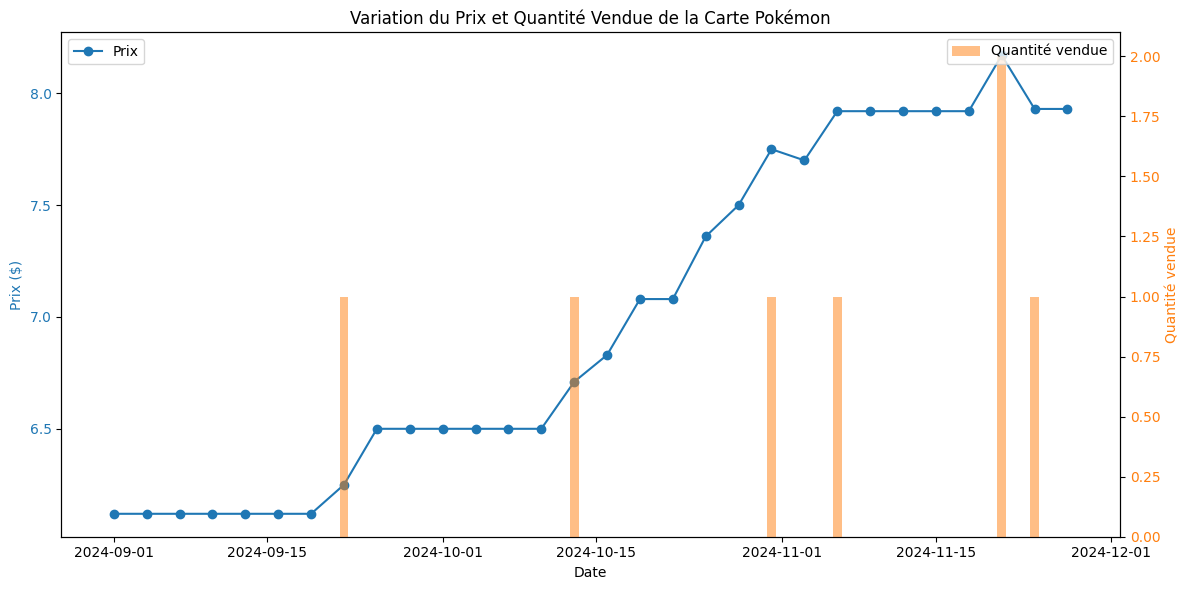

In [23]:
plot_price_quantity_variation(x)

In [29]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# URL de la page

# Configuration du WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = Options()
chrome_options.add_argument("--headless")  # Mode headless
driver = webdriver.Chrome(service=service, options=chrome_options)

try:
    # Charger la page
    driver.get(website)
    
    # Attendre que le bouton "1Y" soit visible et cliquable
    one_year_button = WebDriverWait(driver, 30).until(
        EC.element_to_be_clickable((By.XPATH, "//button[@class='charts-item' and text()='1Y']"))
    )
    print("clic effectué!!!")

    
    # Cliquer sur le bouton pour afficher les données sur 1 an
    one_year_button.click()

    # Attendre que le graphique se mette à jour avec les données de 1 an
    WebDriverWait(driver, 30).until(
        EC.presence_of_element_located((By.XPATH, "//div[@class='martech-charts-history' and @data-testid='History']"))
    )
    
    # Extraire le contenu HTML du graphique
    chart_div = driver.find_element(By.XPATH, "//div[@class='martech-charts-history' and @data-testid='History']")
    
    # Extraire le contenu HTML
    html_content = chart_div.get_attribute('outerHTML')
    print("Contenu HTML récupéré :")
    print(html_content)

except Exception as e:
    print(f"Erreur lors de la récupération des données : {e}")

finally:
    # Fermer le WebDriver
    driver.quit()


Erreur lors de la récupération des données : Message: 
Stacktrace:
0   chromedriver                        0x00000001013bee82 chromedriver + 6696578
1   chromedriver                        0x00000001013b6c9a chromedriver + 6663322
2   chromedriver                        0x0000000100dbee3e chromedriver + 405054
3   chromedriver                        0x0000000100e0f815 chromedriver + 735253
4   chromedriver                        0x0000000100e0fd11 chromedriver + 736529
5   chromedriver                        0x0000000100e5a314 chromedriver + 1041172
6   chromedriver                        0x0000000100e3489d chromedriver + 886941
7   chromedriver                        0x0000000100e573f4 chromedriver + 1029108
8   chromedriver                        0x0000000100e34613 chromedriver + 886291
9   chromedriver                        0x0000000100e01950 chromedriver + 678224
10  chromedriver                        0x0000000100e0234e chromedriver + 680782
11  chromedriver                      

In [33]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Configuration du WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = Options()
#chrome_options.add_argument("--headless")  # Mode headless
driver = webdriver.Chrome(service=service, options=chrome_options)

try:
    # Charger la page
    driver.get(website)
    
    # Attendre que le bouton "1Y" soit visible et cliquable
    one_year_button = WebDriverWait(driver, 40).until(
        EC.element_to_be_clickable((By.XPATH, "//button[@class='charts-item' and text()='1Y']"))
    )
    
    # Cliquer sur le bouton pour afficher les données sur 1 an
    one_year_button.click()

    # Attendre un petit moment que la page réagisse
    WebDriverWait(driver, 5).until(
        EC.staleness_of(one_year_button)  # S'assurer que l'état du bouton a changé
    )

    # Vérifier si le bouton "1Y" est maintenant actif
    active_button = driver.find_element(By.XPATH, "//button[@class='charts-item' and text()='1Y']")
    
    if active_button:
        print("Le clic a été effectué avec succès et le bouton '1Y' est maintenant actif.")
    else:
        print("Le clic n'a pas été effectué ou le bouton '1Y' n'est pas actif.")
    
except Exception as e:
    print(f"Erreur lors de la vérification du clic : {e}")

finally:
    # Fermer le WebDriver
    driver.quit()


Erreur lors de la vérification du clic : Message: 
Stacktrace:
0   chromedriver                        0x0000000102762e82 chromedriver + 6696578
1   chromedriver                        0x000000010275ac9a chromedriver + 6663322
2   chromedriver                        0x0000000102162e3e chromedriver + 405054
3   chromedriver                        0x00000001021b3815 chromedriver + 735253
4   chromedriver                        0x00000001021b3d11 chromedriver + 736529
5   chromedriver                        0x00000001021fe314 chromedriver + 1041172
6   chromedriver                        0x00000001021d889d chromedriver + 886941
7   chromedriver                        0x00000001021fb3f4 chromedriver + 1029108
8   chromedriver                        0x00000001021d8613 chromedriver + 886291
9   chromedriver                        0x00000001021a5950 chromedriver + 678224
10  chromedriver                        0x00000001021a634e chromedriver + 680782
11  chromedriver                        0x

In [44]:
###jdjnncbdd d

def setup_driver():
    service = Service(ChromeDriverManager().install())
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--window-size=1920,1080")  # Définir une taille d'écran standard
    #chrome_options.add_argument("--disable-gpu")
    return webdriver.Chrome(service=service, options=chrome_options)

def wait_and_click_button(driver, wait):
    try:
        # Essayer d'abord avec le sélecteur CSS plus précis basé sur l'image
        one_year_button = wait.until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-v-0177b97d][class*="charts-item"]:last-child'))
        )
        
        # Scroll jusqu'au bouton pour s'assurer qu'il est visible
        driver.execute_script("arguments[0].scrollIntoView(true);", one_year_button)
        time.sleep(1)  # Petit délai pour laisser le scroll se terminer
        
        try:
            one_year_button.click()
        except ElementClickInterceptedException:
            # Si le clic direct échoue, essayer avec JavaScript
            driver.execute_script("arguments[0].click();", one_year_button)
        
        print("Clic sur le bouton 1Y effectué avec succès!")
        return True
        
    except TimeoutException:
        print("Le bouton 1Y n'a pas été trouvé avec le premier sélecteur, essai avec alternative...")
        try:
            # Essayer avec un sélecteur alternatif
            one_year_button = wait.until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'charts-item') and contains(text(), '1Y')]"))
            )
            driver.execute_script("arguments[0].click();", one_year_button)
            print("Clic sur le bouton 1Y effectué avec succès (méthode alternative)!")
            return True
        except TimeoutException:
            print("Impossible de trouver le bouton 1Y même avec le sélecteur alternatif.")
            return False

def get_chart_data(driver, wait):
    try:
        # Attendre que le graphique soit mis à jour
        chart = wait.until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.martech-charts-history[data-testid='History']"))
        )
        
        # Attendre un court instant pour que les données se chargent
        time.sleep(2)
        
        return chart.get_attribute('outerHTML')
    except TimeoutException:
        print("Impossible de trouver le graphique après le clic.")
        return None

def extract_html_code_1Y(website):
    driver = setup_driver()
    wait = WebDriverWait(driver, 20)
    
    try:
        # Charger la page
        driver.get(website)
        print("Page chargée avec succès")
        
        # Attendre que la page soit complètement chargée
        wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
        
        # Cliquer sur le bouton 1Y
        if wait_and_click_button(driver, wait):
            # Attendre et récupérer les données du graphique
            html_content = get_chart_data(driver, wait)
            if html_content:
                print("Contenu HTML récupéré avec succès:")
                print(html_content)
            else:
                print("Échec de la récupération du contenu HTML")
        else:
            print("Échec du clic sur le bouton 1Y")
            
    except Exception as e:
        print(f"Une erreur est survenue : {str(e)}")
        
    finally:
        driver.quit()
        print("Navigation terminée - Driver fermé")
    return html_content


In [45]:
html_content=extract_html_code_1Y(website)
print(html_content)

Page chargée avec succès
Clic sur le bouton 1Y effectué avec succès!
Contenu HTML récupéré avec succès:
<div data-v-85056b11="" class="martech-charts-history" data-testid="History"><div data-v-85056b11="" class="martech-charts-content"><!----><div data-v-85056b11="" class="martech-charts-header-controls"><div data-v-eefc313a="" data-v-85056b11="" class="charts-header" data-testid="History__Default"><div data-v-eefc313a="" class="charts-row"><div data-v-eefc313a="" class="charts-color" style="background-color: rgb(242, 249, 255);"><div data-v-eefc313a="" class="charts-group" style="color: rgb(8, 53, 219);"><svg data-v-eefc313a="" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 40 28" class="graph-icon"><path d="M20.5 28c-1.1 0-2-.9-2-2V3h-7v10.5c0 1.1-.9 2-2 2h-9c-.28 0-.5-.22-.5-.5v-2c0-.28.22-.5.5-.5h8V2c0-1.1.9-2 2-2h9c1.1 0 2 .9 2 2v23h7V14.5c0-1.1.9-2 2-2h9c.28 0 .5.22.5.5v2c0 .28-.22.5-.5.5h-8V26c0 1.1-.9 2-2 2h-9Z" fill="currentColor"></path></svg><div data-v-eefc313a="" class="c

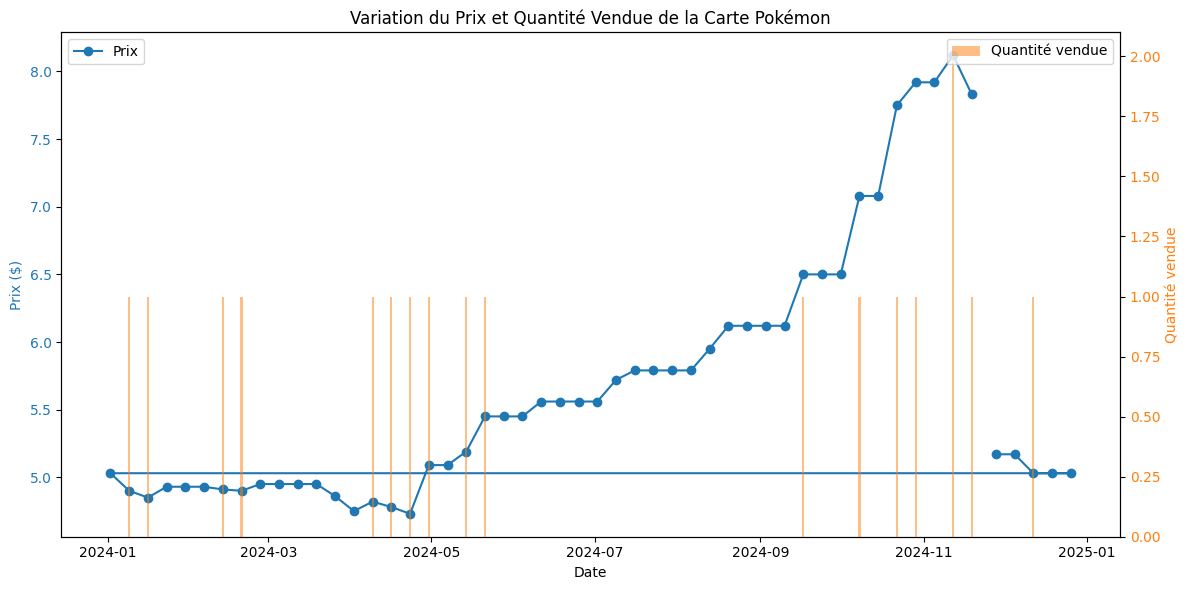

In [46]:
prices=extract_price_history(html_content)
plot_price_quantity_variation(prices)
    

In [47]:
from extract_historic_prices import extract_html_code_1Y

In [48]:
website="https://prices.pokemontcg.io/tcgplayer/dp3-2"
html_content=extract_html_code_1Y(website)

Page chargée avec succès
Clic sur le bouton 1Y effectué avec succès!
Contenu HTML récupéré avec succès:
<div data-v-85056b11="" class="martech-charts-history" data-testid="History"><div data-v-85056b11="" class="martech-charts-content"><!----><div data-v-85056b11="" class="martech-charts-header-controls"><div data-v-eefc313a="" data-v-85056b11="" class="charts-header" data-testid="History__Default"><div data-v-eefc313a="" class="charts-row"><div data-v-eefc313a="" class="charts-color" style="background-color: rgb(242, 249, 255);"><div data-v-eefc313a="" class="charts-group" style="color: rgb(8, 53, 219);"><svg data-v-eefc313a="" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 40 28" class="graph-icon"><path d="M20.5 28c-1.1 0-2-.9-2-2V3h-7v10.5c0 1.1-.9 2-2 2h-9c-.28 0-.5-.22-.5-.5v-2c0-.28.22-.5.5-.5h8V2c0-1.1.9-2 2-2h9c1.1 0 2 .9 2 2v23h7V14.5c0-1.1.9-2 2-2h9c.28 0 .5.22.5.5v2c0 .28-.22.5-.5.5h-8V26c0 1.1-.9 2-2 2h-9Z" fill="currentColor"></path></svg><div data-v-eefc313a="" class="c

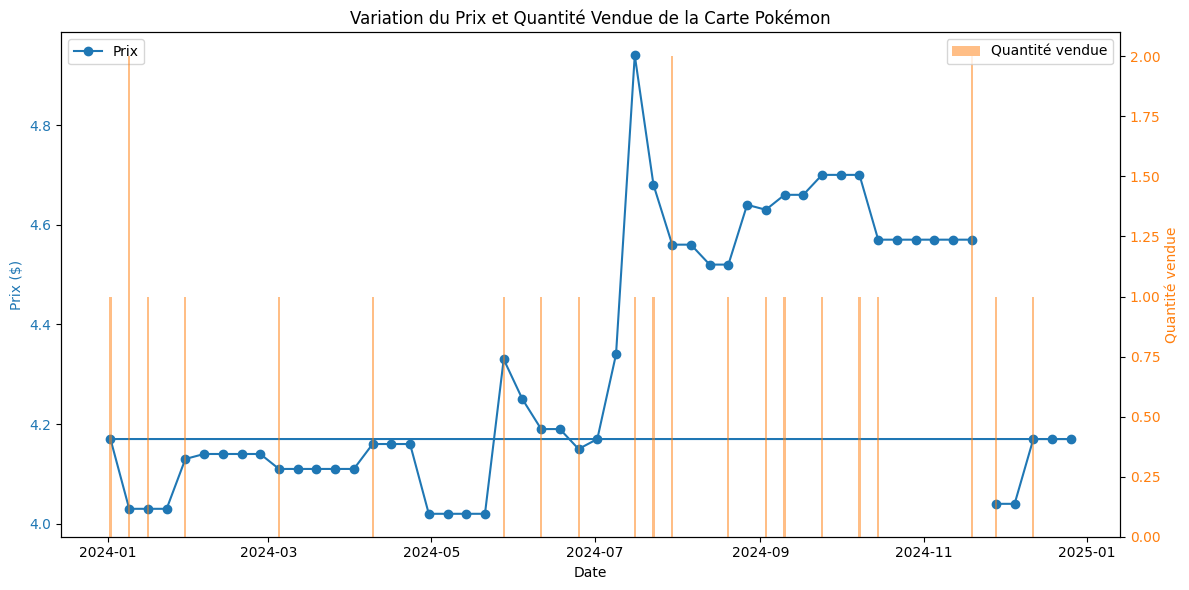

In [49]:
prices=extract_price_history(html_content)
plot_price_quantity_variation(prices)